In [2]:
from __future__ import print_function, division

from google.colab import files
#from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Concatenate
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam

from keras.preprocessing import image
from keras.utils import to_categorical

import matplotlib.pyplot as plt

import numpy as np
import os, cv2


In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
class CGAN():
    def __init__(self):
        # Input shape
        #rows and cols are changed from 28 to 224
        self.img_rows = 224
        self.img_cols = 224
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        #only 2 classes positive and negative
        #self.num_classes = 2
        self.latent_dim = 100

        self.dis_loss_hist=[]
        self.dis_acc_hist=[]
        self.gen_loss_hist=[]

        optimizer = Adam(0.02, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        #label = Input(shape=(1,))
        img = self.generator(noise)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model(noise, valid)
        self.combined.compile(loss=['binary_crossentropy'],
            optimizer=optimizer)

    def build_generator(self):
        
        model = Sequential()
        # foundation for 56x56 image
        n_nodes = 256 * 28 * 28
        model.add(Dense(n_nodes, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Reshape((28, 28, 256)))
        # upsample to 112x112
        model.add(Conv2DTranspose(256, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        # upsample to 112x112
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        # upsamplde to 224x224
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(1, (7,7), activation='tanh', padding='same'))
        # model = Sequential()
        
        # model.add(Dense(128 * 28 * 28, input_dim=self.latent_dim))
        # model.add(LeakyReLU(alpha=0.2))
        # model.add(Reshape((28, 28, 128)))
        # # upsample to 56x56(14x14)
        # model.add(UpSampling2D())
        # model.add(Conv2D(128, kernel_size=3, padding="same"))
        # model.add(BatchNormalization(momentum=0.8))
        # model.add(LeakyReLU(alpha=0.2))
        # # upsample to 112x112(14x14)
        # model.add(UpSampling2D())
        # model.add(Conv2D(64, kernel_size=3, padding="same"))
        # model.add(BatchNormalization(momentum=0.8))
        # model.add(LeakyReLU(alpha=0.2))
        # # upsample to 224x224(28x28)
        # model.add(UpSampling2D())
        # model.add(Conv2D(64, kernel_size=3, padding="same"))
        # model.add(BatchNormalization(momentum=0.8))
        # model.add(LeakyReLU(alpha=0.2))                                        
        # model.add(Conv2D(1, kernel_size=4, activation='tanh', padding='same'))  
        
        model.summary()
        
        noise = Input(shape=(self.latent_dim,))
#         label = Input(shape=(1, ), dtype='int32')                                
#         label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))
                             
#         model_input = multiply([noise, label_embedding])
        img = model(noise)
        
        return Model(noise, img)
        

    def build_discriminator(self):    

        model = Sequential()

        model.add(Conv2D(64, (3,3), padding='same', input_shape=self.img_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Flatten())
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))
        # model.add(Conv2D(32,
        #            kernel_size=3,
        #            strides=2,
        #            input_shape=self.img_shape,
        #            padding='same'))
        # model.add(LeakyReLU(alpha=0.2))
        # model.add(Dropout(0.3))
        # model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        # model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        # model.add(BatchNormalization(momentum=0.8))
        # model.add(LeakyReLU(alpha=0.2))
        # model.add(Dropout(0.3))
        # model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        # model.add(BatchNormalization(momentum=0.8))
        # model.add(LeakyReLU(alpha=0.2))
        # model.add(Dropout(0.3))
        # model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        # model.add(BatchNormalization(momentum=0.8))
        # model.add(Flatten())
        # model.add(Dropout(0.3))
        # model.add(Dense(1, activation='sigmoid'))
        model.summary()
        
        img = Input(shape=self.img_shape)
#         label = Input(shape=(1,), dtype='int32')

#         label_embedding = Flatten()(Embedding(self.num_classes, 
#                                               np.prod(self.img_shape))(label))
#         label_embedding = Reshape(self.img_shape)(label_embedding)
#         flat_img = Flatten()(img)
        
        #multiply([flat_img, label_embedding])
#        model_input = multiply([flat_img, label_embedding])#Concatenate(axis=-1)([img, label_embedding])

        validity = model(img)#model(model_input)

        return Model(img, validity)
        

    def train(self, epochs, batch_size, sample_interval):

        # Load the dataset
#         (X_train, y_train), (_, _) = mnist.load_data()
        data_path = "/content/drive/My Drive/Colab Notebooks/DMV_Assess_1_Covid-19_Dataset/"
        X_train = []
        #y_train = []        

        for folder in os.listdir(data_path):
            if folder == "Covid-19" or folder == "Covid-19":
                for file in os.listdir(os.path.join(data_path, folder)):
                    try:
                        i_path = os.path.join(data_path, folder,  file)
                        l_img = cv2.imread(i_path, cv2.IMREAD_GRAYSCALE)
                        l_img = cv2.resize(l_img, (224,224))
                        l_img = np.array(l_img)
                        l_img = (l_img.astype('float32') - 127.5) / 127.5
                        #img /= 255 
                        X_train.append(l_img)
#                         if folder == "Normal":
#                             y_train.append([0])
#                         else:
#                             y_train.append([1])

                    except Exception as e:
                        print(e)
                        print("error in " + i_path)
                        continue

#         # Configure input
#         X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
#         y_train = np.array(y_train)
#         y_train = y_train.reshape(-1, 1)

#         print("X--s", X_train)
#         print("y--s", y_train)
        
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            #imgs, labels = X_train[idx], y_train[idx]
            imgs = X_train[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            #store discriminator history
            self.dis_loss_hist.append(d_loss[0])
            self.dis_acc_hist.append(d_loss[1])

            # ---------------------
            #  Train Generator
            # ---------------------

            # Condition on labels
            #sampled_labels = np.random.randint(0, 2, batch_size).reshape(-1, 1)

            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid)

            self.gen_loss_hist.append(g_loss)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
#         r, c = 2, 5
#         noise = np.random.normal(0, 1, (r * c, 100))
#         sampled_labels = np.arange(0, 10).reshape(-1, 1)

#         gen_imgs = self.generator.predict([noise, sampled_labels])

#         # Rescale images 0 - 1
#         gen_imgs = 0.5 * gen_imgs + 0.5

#         fig, axs = plt.subplots(r, c)
#         cnt = 0
#         for i in range(r):
#             for j in range(c):
#                 axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
#                 axs[i,j].set_title("Digit: %d" % sampled_labels[cnt])
#                 axs[i,j].axis('off')
#                 cnt += 1
#         fig.savefig("images/%d.png" % epoch)
#         plt.close()
        noise = np.random.normal(0, 1, (10, self.latent_dim))
        sampled_labels = np.arange(0, 2).reshape(-1, 1)
        gen_imgs = self.generator.predict(noise)
        
        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
        
        #Save generated image
        # turn off axis
        plt.axis('off')
        plt.imshow(gen_imgs[0,:,:,0], cmap='gray')
        plt.savefig("/content/drive/My Drive/Colab Notebooks/DMV_Assess_1_Covid-19_Dataset/images/%d.png" % epoch)
        plt.close()

    def plot_loss(self):
      plt.plot(self.dis_loss_hist)
      plt.plot(self.dis_acc_hist)
      plt.plot(self.gen_loss_hist)
      plt.legend(["D_loss", "D_accuracy", "G_loss"])
      
      plt.xlabel("Epoch")
      plt.ylabel("Value")

      plt.show()

In [4]:
#path"D:\MScAI\Semester2\CS551G_Data Mining and Visualisation\Assessm1\DMV_Assess_1_Covid-19_Dataset\Covid-19"
os.chdir('/content/drive/My Drive/Colab Notebooks/DMV_Assess_1_Covid-19_Dataset/')

In [5]:
#covid_img_path = "D:/MScAI/Semester2/CS551G_Data Mining and Visualisation/Assessm1/DMV_Assess_1_Covid-19_Dataset/Covid-19/"
#normal_img_path = "D:/MScAI/Semester2/CS551G_Data Mining and Visualisation/Assessm1/DMV_Assess_1_Covid-19_Dataset/Normal/"
data_path = "/content/drive/My Drive/Colab Notebooks/DMV_Assess_1_Covid-19_Dataset/"

In [ ]:
hight = []
width = []

for folder in os.listdir(data_path):
    for file in os.listdir(os.path.join(data_path, folder)):
        try:
            i_path = os.path.join(data_path, folder,  file)
            img = cv2.imread(i_path, cv2.IMREAD_GRAYSCALE)
            h, w = img.shape[:2]
            hight.append(h)
            width.append(w)       


        except Exception as e:
            print(e)
            print("error in "+filename)
            continue
        
print ('Min image hight:', min(hight), hight.index(min(hight)))
print ('Min image width:', min(width), width.index(min(width)))

NotADirectoryError: ignored

In [ ]:
cgan = CGAN()
cgan.train(epochs=100, batch_size=64, sample_interval=2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 224, 224, 64)      640       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 224, 224, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 56, 56, 64)        36928     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 64)       

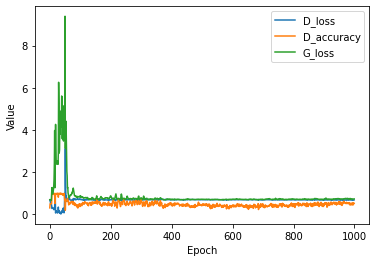

In [ ]:
cgan.plot_loss()

In [ ]:
for i in range(0,50):
    noise = np.random.normal(0, 10, (10, 100))
    sampled_labels = np.arange(0, 2).reshape(-1, 1)
    gen_imgs = cgan.generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    #Save generated image
    # turn off axis
    plt.axis('off')
    plt.imshow(gen_imgs[0,:,:,0], cmap='gray')
    plt.savefig("/content/drive/My Drive/Colab Notebooks/DMV_Assess_1_Covid-19_Dataset/images50/%d.png" % i)
    plt.close()

# Task 2

In [6]:
covid_labels = []
normal_labels = []

covid_images=[]
normal_images=[]

count = 0
for folder in os.listdir(data_path):
  if folder == "Covid-19":    
    for file in os.listdir(os.path.join(data_path, folder)):
      i_path = os.path.join(data_path, folder,  file)
      if count<50:
        try:
          l_img = cv2.imread(i_path,cv2.IMREAD_GRAYSCALE)
          l_img = cv2.resize(l_img, (224,224))
          l_img = np.array(l_img)
          l_img = (l_img.astype('float32')) / 255
          #l_img = (l_img.astype('float32') - 127.5) / 127.5
          #img /= 255 
          covid_images.append(l_img)
          covid_labels.append([1])
          count +=1        

        except Exception as e:
            print(e)
            print("error in " + i_path)
            continue

          
  elif folder == "Normal":    
    for file in os.listdir(os.path.join(data_path, folder)):
      i_path = os.path.join(data_path, folder,  file)
      try:        
        l_img = cv2.imread(i_path,cv2.IMREAD_GRAYSCALE)
        l_img = cv2.resize(l_img, (224,224))
        l_img = np.array(l_img)
        l_img = (l_img.astype('float32')) / 255
        #img /= 255 
        normal_images.append(l_img)
        normal_labels.append([0])    

      except Exception as e:
        print(e)
        print("error in " + i_path)
        continue

  elif folder == "images50":    
    for file in os.listdir(os.path.join(data_path, folder)):
      i_path = os.path.join(data_path, folder,  file)
      try:        
        l_img = cv2.imread(i_path,cv2.IMREAD_GRAYSCALE)
        l_img = cv2.resize(l_img, (224,224))
        l_img = np.array(l_img)
        l_img = (l_img.astype('float32')) / 255
        #img /= 255 
        covid_images.append(l_img)
        covid_labels.append([1])    

      except Exception as e:
        print(e)
        print("error in " + i_path)
        continue
#         # Configure input
#         X_train = (X_train.astype(np.float32) - 127.5) / 127.5
covid_images = np.array(covid_images)
#covid_images[0] = np.delete(covid_images[0],0,0)
normal_images = np.array(normal_images)
#normal_images[0] = np.delete(normal_images[0],0,0)


# X = np.expand_dims(X, axis=3)
covid_labels = np.array(covid_labels)
normal_labels = np.array(normal_labels)
# y = y.reshape(-1, 1)

In [7]:
print(normal_images.shape)
print(covid_images.shape)

(100, 224, 224)
(100, 224, 224)


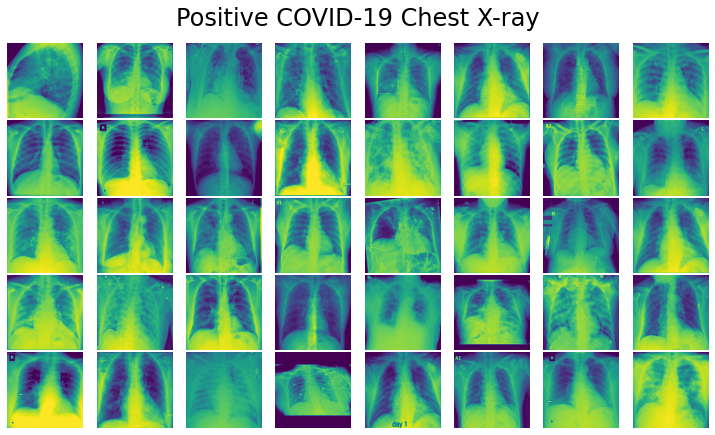

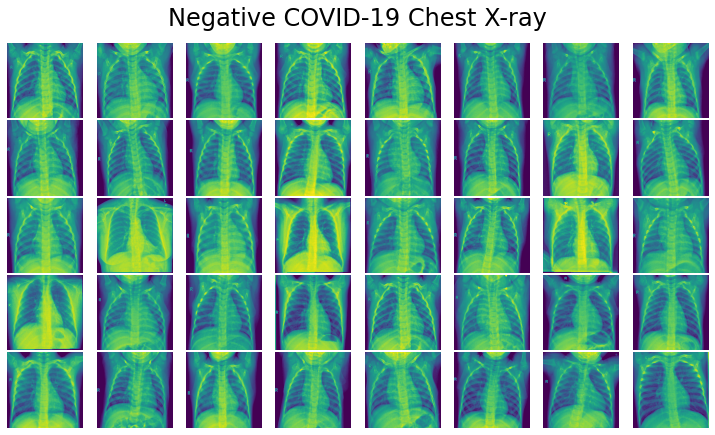

In [8]:
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(covid_images, 'Positive COVID-19 Chest X-ray')
plot_images(normal_images, 'Negative COVID-19 Chest X-ray')

In [9]:
print(normal_images.shape)
covid_images = np.repeat(covid_images[..., np.newaxis], 3, -1)
normal_images = np.repeat(normal_images[..., np.newaxis], 3, -1)
print(covid_images.shape)

(100, 224, 224)
(100, 224, 224, 3)


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# split into training and testing
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    normal_images, normal_labels, test_size=0.2)


X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

In [11]:
from __future__ import print_function, division
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

res = ResNet50(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = res.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=res.input, outputs=outputs)

for layer in res.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

94773248/94765736 [==============================] - 1s 0us/step


In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [14]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=500)

Epoch 1/500
5/5 [==============================] - 35s 563ms/step - loss: 4.6725 - accuracy: 0.5512 - val_loss: 4.7610 - val_accuracy: 0.5000
Epoch 2/500
5/5 [==============================] - 2s 344ms/step - loss: 3.8949 - accuracy: 0.5448 - val_loss: 1.6352 - val_accuracy: 0.5000
Epoch 3/500
5/5 [==============================] - 2s 348ms/step - loss: 1.1522 - accuracy: 0.7026 - val_loss: 0.6996 - val_accuracy: 0.8000
Epoch 4/500
5/5 [==============================] - 2s 342ms/step - loss: 0.8309 - accuracy: 0.6501 - val_loss: 0.7049 - val_accuracy: 0.8000
Epoch 5/500
5/5 [==============================] - 2s 346ms/step - loss: 1.0792 - accuracy: 0.7062 - val_loss: 0.2712 - val_accuracy: 0.9000
Epoch 6/500
5/5 [==============================] - 2s 352ms/step - loss: 0.7017 - accuracy: 0.6756 - val_loss: 0.3084 - val_accuracy: 0.9500
Epoch 7/500
5/5 [==============================] - 2s 350ms/step - loss: 0.7024 - accuracy: 0.6869 - val_loss: 0.4200 - val_accuracy: 0.8000
Epoch 8/500


In [ ]:
model.save('resnet_chest.h5')
model.save_weights('resnetweights_chest.hdf5')

In [ ]:
model = load_model('resnet_chest.h5')

NameError: ignored

In [16]:
batch_size = 32
y_pred = model.predict(X_test, batch_size=batch_size)

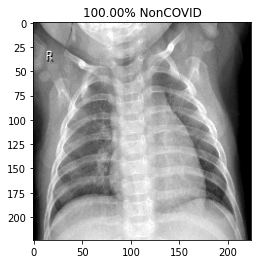

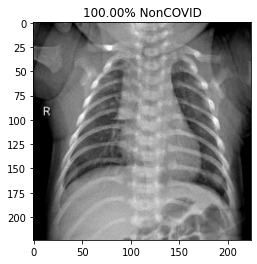

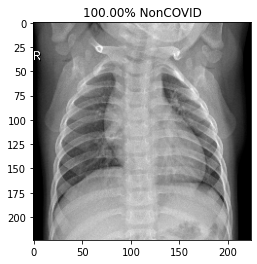

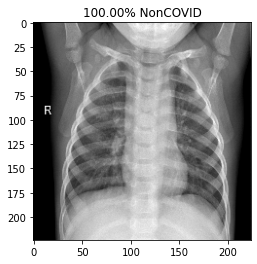

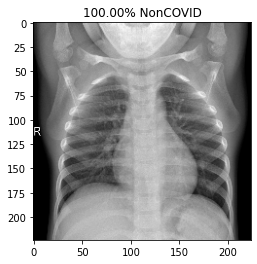

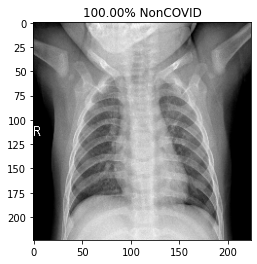

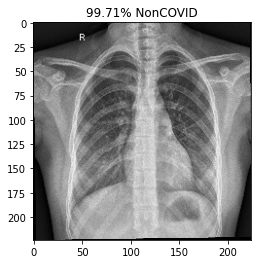

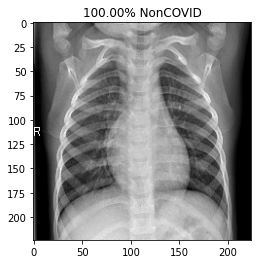

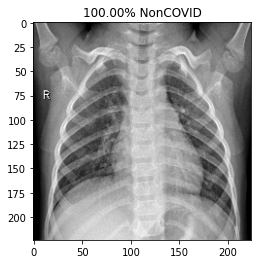

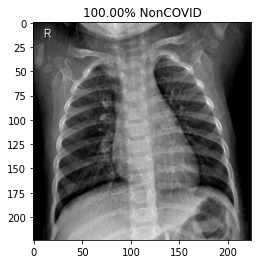

In [17]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
  plt.imshow(X_test[index])
  plt.show()

In [18]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.95      1.00      0.98        20

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



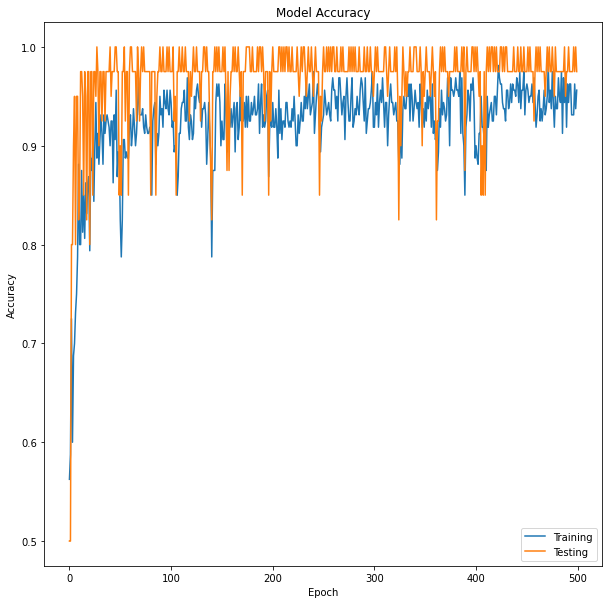

In [20]:
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('resnet_chest_accuracy.png')
plt.show()